![banner cnns ppgcc ufsc](../banner.png)

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.00-IPython-Beyond-Normal-Python.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Python-v.3.7-green.png" alt="Python Version" title="Python Version"></a>

# 10.1.Extração de Características com Métodos Geométricos e a Transformada de Hough


Muitas vezes nós queremos extrair de uma imagem objetos de uma determinada geometria: retas, círculos, elipses ou mesmo geometrias mais complexas. Por que não usar uma descrição baseada nas fórmulas da Geometria Analítica para isso? 

É essa a ideia por detrás da transformada de Hough: representar a resposta de determinadas regiões da imagem à aplicação de fórmulas da geometria analítica em uma espécie de "espaço de fase" onde registramos a probabilidade acumulada de diferentes regiões da imagem possuírem objetos com diferentes geometrias, o acumulador de Hough.

Aplicar a transformada de Hough para a geometrias mais complexas como círculos, elipses ou mesmo geometrias arbitrárias é computacionalmente bastante intenso e é pouco usado. A aplicação principal é a da transformada de Hough para segmentos de reta que é leve o suficiente para poder ser executada em tempo real em algoritmos como um detector de faixa lateral para navegação veicular autônoma, como vimos no vídeo da nossa aula. Se você tem tempo para esperar o processamento, a transformada para círculos pode ser usada em aplicações como a contagem de microrganismos em amostras de água, por exemplo, onde não existe um requisito de tempo real.



### Preprocessing

Images that will be processed by some implementations of the Hough transform are usually preprocessed with tha ***Canny Edge Detector***: https://docs.opencv.org/3.1.0/da/d22  The OpenCV docs are in: https://docs.opencv.org/3.1.0/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de/tutorial_py_canny.html


Algorithm overview
------------------

Usually, lines are parameterised as $y = mx + c$, with a gradient
$m$ and y-intercept `c`. However, this would mean that $m$ goes to
infinity for vertical lines. Instead, we therefore construct a segment
perpendicular to the line, leading to the origin. The line is represented by
the length of that segment, $r$, and the angle it makes with the x-axis,
$\theta$.

The Hough transform constructs a histogram array representing the parameter
space (i.e., an $M \times N$ matrix, for $M$ different values of
the radius and $N$ different values of $\theta$).  For each
parameter combination, $r$ and $\theta$, we then find the number of
non-zero pixels in the input image that would fall close to the corresponding
line, and increment the array at position $(r, \theta)$ appropriately.

We can think of each non-zero pixel "voting" for potential line candidates. The
local maxima in the resulting histogram indicates the parameters of the most
probably lines. In our example, the maxima occur at 45 and 135 degrees,
corresponding to the normal vector angles of each line.

Another approach is the Progressive Probabilistic Hough Transform [2]_. It is
based on the assumption that using a random subset of voting points give a good
approximation to the actual result, and that lines can be extracted during the
voting process by walking along connected components. This returns the
beginning and end of each line segment, which is useful.

The function `probabilistic_hough` has three parameters: a general threshold
that is applied to the Hough accumulator, a minimum line length and the line
gap that influences line merging. In the example below, we find lines longer
than 10 with a gap less than 3 pixels.

References
----------

.. [1] Duda, R. O. and P. E. Hart, "Use of the Hough Transformation to Detect Lines and Curves in Pictures," Comm. ACM, Vol. 15, pp. 11-15 (January, 1972)

.. [2] C. Galamhos, J. Matas and J. Kittler,"Progressive probabilistic Hough transform for line detection", in IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 1999.




### Initializations

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from scipy import ndimage
import numpy as np
import cv2
from scipy import ndimage
from matplotlib import pyplot as plt
from ipywidgets import interact_manual

# Test if your notebook is running on Google Colab
# You'll use this when choosing between doing interaction via ipywidgets or not. 
try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)

Running on Google Colab =  False


In [6]:
def to_gray(image):
     # If the image is colored, make a grayscale copy
    if image.shape[-1] == 3:           
        b,g,r = cv2.split(image)       # get b,g,r
        rgb_img = cv2.merge([r,g,b])     # switch it to rgb
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = image
    return gray_img

### Data Sources

We will be using the ***scikit data module*** to provide us with an image data source. Look here to learn what it is: http://scikit-image.org/docs/dev/api/skimage.data.html It provides the following images:

 - skimage.data.astronaut() - Color image of the astronaut Eileen Collins.

 - skimage.data.binary_blobs([length, …]) - Generate synthetic binary image with several rounded blob-like objects.

 - skimage.data.camera() - Gray-level “camera” image.

 - skimage.data.checkerboard() - Checkerboard image.

 - skimage.data.chelsea() - Chelsea the cat.

 - skimage.data.clock() - Motion blurred clock.

 - skimage.data.coffee() - Coffee cup.

 - skimage.data.coins() - Greek coins from Pompeii.

 - skimage.data.horse() - Black and white silhouette of a horse.

 - skimage.data.hubble_deep_field() - Hubble eXtreme Deep Field.

 - skimage.data.immunohistochemistry() - Immunohistochemical (IHC) staining with hematoxylin counterstaining.

 - skimage.data.lbp_frontal_face_cascade_filename() - Returns the path to the XML file containing information about the weak classifiers of a cascade classifier trained using LBP features.

 - skimage.data.lfw_subset() - Subset of data from the LFW dataset.

 - skimage.data.logo() - Scikit-image logo, a RGBA image.

 - skimage.data.microaneurysms() - Gray-level “microaneurysms” image.

 - skimage.data.moon() - Surface of the moon.

 - skimage.data.page() - Scanned page.

 - skimage.data.text() - Gray-level “text” image used for corner detection.

 - skimage.data.retina() - Human retina.

 - skimage.data.rocket() - Launch photo of DSCOVR on Falcon 9 by SpaceX.

 - skimage.data.stereo_motorcycle() - Rectified stereo image pair with ground-truth disparities.

In [7]:
import skimage

sources = [
     'skimage.data.astronaut()',
     'skimage.data.camera()',
     'skimage.data.checkerboard()',
     'skimage.data.chelsea()',
     'skimage.data.clock()',
     'skimage.data.coffee()',
     'skimage.data.coins()',
     'skimage.data.horse()',
     'skimage.data.hubble_deep_field()',
     'skimage.data.immunohistochemistry()',
     'skimage.data.lbp_frontal_face_cascade_filename()',
     'skimage.data.lfw_subset()',
     'skimage.data.logo()',
     'skimage.data.microaneurysms()',
     'skimage.data.moon()',
     'skimage.data.page()',
     'skimage.data.text()',
     'skimage.data.retina()',
     'skimage.data.rocket()',
     'skimage.data.stereo_motorcycle()']

# Hough Lines

## SciKit

The Canny Edge Detector we are using here is this one: http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html Function documentation is here: https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/_canny.py

In [10]:
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm


def houghLinesSciKit(source, sigma, low_threshold, high_threshold,
                    threshold, line_length, line_gap, probabilistic):
    # Line finding using the Probabilistic Hough Transform
    image = to_gray(eval(source))
    edges = canny(image, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)
    if probabilistic:
        lines = probabilistic_hough_line(edges, threshold=threshold, line_length=line_length, line_gap=line_gap)
    else:
        lines = hough_line(edges)

    # Generating figure 2
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image, cmap=cm.gray)
    ax[0].set_title('Input image')

    ax[1].imshow(edges, cmap=cm.gray)
    ax[1].set_title('Canny edges')

    ax[2].imshow(edges * 0)
    for line in lines:
        # print(line)
        p0, p1 = line
        ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
    ax[2].set_xlim((0, image.shape[1]))
    ax[2].set_ylim((image.shape[0], 0))
    ax[2].set_title('Probabilistic Hough')

    for a in ax:
        a.set_axis_off()

    plt.tight_layout()
    plt.show()
    
if _ON_COLAB:
    # Google Colab:
    houghLinesSciKit(source='skimage.data.coffee()',sigma=2, low_threshold=1, high_threshold=25, threshold=10, 
                    line_length=5, line_gap=3, probabilistic=True)
else:
    # Jupyter Notebook:
    interact_manual(houghLinesSciKit, source=sources, sigma=2, low_threshold=1, high_threshold=25, threshold=10, 
                    line_length=5, line_gap=3, probabilistic=True)

interactive(children=(Dropdown(description='source', options=('skimage.data.astronaut()', 'skimage.data.camera…

## OpenCV

* [OpenCV-Python Tutorials::Hough Line Transform](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)

In [11]:
from skimage import data
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [20,7]


def houghLinesOpenCV(source, threshold1,threshold2,apertureSize,L2gradient,
                     rho,theta,threshold):
    image = eval(source)

    # If the image is colored, make a grayscale copy
    if image.shape[-1] == 3:           
        print('color image')
        b,g,r = cv2.split(image)       # get b,g,r
        rgb_img = cv2.merge([r,g,b])     # switch it to rgb
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        print('gray image')
        gray_img = image

    # Blur the image 
    img = cv2.medianBlur(gray_img, 5)
    # Create a grayscale version that allows colored painting on it
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Create an edge image with the OpenCV canny implementation
    edges = cv2.Canny(gray_img,threshold1=threshold1,threshold2=threshold2,apertureSize=apertureSize, L2gradient=L2gradient)
    # apertureSize is the aperture size for the Sobel edge detection operator

    # Detect the lines in the image and store them in a list
    # lines = cv2.HoughLines(edges,rho=rho,theta=theta,threshold=threshold)
    lines = cv2.HoughLines(edges,1,np.pi/180,200)
    # print(lines)
    
    # Traverse the list and paint each line on the color-capable image
    try:
        for line_rho,line_theta in lines[0]:
            a = np.cos(line_theta)
            b = np.sin(line_theta)
            x0 = a*line_rho
            y0 = b*line_rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            cv2.line(cimg,(x1,y1),(x2,y2),(0,0,255),1)
    except:
        print('No lines found...')
        
    # Write the result on the disk
    #cv2.imwrite('houghlines3.jpg',img)
    
    # Create a row of three plots to show the image, edges and result
    plt.subplot(131),plt.imshow(cv2.cvtColor(gray_img,cv2.COLOR_GRAY2BGR))
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(132),plt.imshow(edges)
    plt.title('Edges Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(133),plt.imshow(cimg)
    plt.title('Hough Transform'), plt.xticks([]), plt.yticks([])
    plt.show()
    
interact_manual(houghLinesOpenCV, source=sources, threshold1=100,threshold2=1000,apertureSize=3,L2gradient=True, rho=50,theta=np.pi/180,threshold=50)
None

interactive(children=(Dropdown(description='source', options=('skimage.data.astronaut()', 'skimage.data.camera…

# Hough Circles

## SciKit

Hough Circles using SciKIt (skimage). The examples below (and also the ellipse example farther below) are inspired on these documentations here:
 - https://scikit-image.org/docs/dev/auto_examples/edges/plot_circular_elliptical_hough_transform.html
 - https://scikit-image.org/docs/0.12.x/auto_examples/edges/plot_circular_elliptical_hough_transform.html

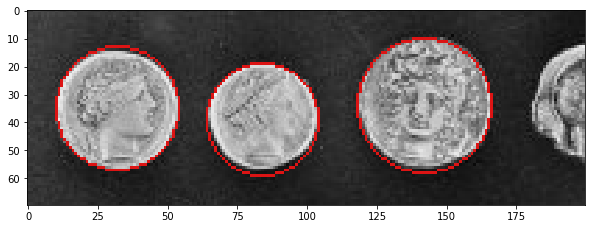

In [12]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte


# Load picture and detect edges
image = img_as_ubyte(data.coins()[160:230, 70:270])
edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)


# Detect two radii
hough_radii = np.arange(20, 35, 2)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 5 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=3)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

## OpenCV

* [OpenCV-Python Tutorials::Hough Circle Transform](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghcircles/py_houghcircles.html)

Docs: https://docs.opencv.org/3.1.0/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d

```python
void cv::HoughCircles 	( 	
        InputArray  	image,
		OutputArray     circles,
		int  	   method,
		double  	dp,
		double  	minDist,
		double  	param1 = 100,
		double  	param2 = 100,
		int  	   minRadius = 0,
		int  	   maxRadius = 0 
	) 	
```
**Parameters**
 - **image**	8-bit, single-channel, grayscale input image.
 - **circles**	Output vector of found circles. Each vector is encoded as a 3-element floating-point vector \((x, y, radius)\) .
 - **method**	Detection method, see *cv::HoughModes*. Currently, the only implemented method is *HOUGH_GRADIENT*
 - **dp**	Inverse ratio of the accumulator resolution to the image resolution. For example, if dp=1 , the accumulator has the same resolution as the input image. If dp=2 , the accumulator has half as big width and height.
 - **minDist**	Minimum distance between the centers of the detected circles. If the parameter is too small, multiple neighbor circles may be falsely detected in addition to a true one. If it is too large, some circles may be missed.
 - **param1**	First method-specific parameter. In case of CV_HOUGH_GRADIENT , it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller).
 - **param2**	Second method-specific parameter. In case of CV_HOUGH_GRADIENT , it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first.
 - **minRadius**	Minimum circle radius.
 - **axRadius**	Maximum circle radius.

For the CLAHE (Contrast Limited Adaptive Histogram Equalization) look here:
  - https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html

color image


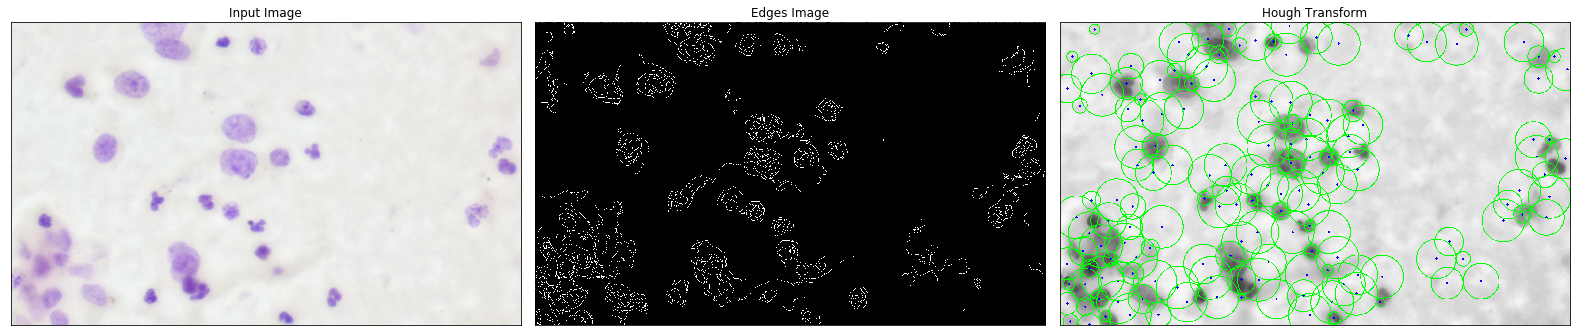

In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import data
from matplotlib import cm
from skimage.feature import canny


image = cv2.imread('../data/dna-cytometry-40x.png') # read as it is
#image = cv2.imread('../data/dna-cytometry-20x.png') # read as it is
#image = cv2.imread('../data/cytometry.jpg') # read as it is
# image = data.clock()


if image.shape[-1] == 3:           
    print('color image')
    b,g,r = cv2.split(image)       # get b,g,r
    image = cv2.merge([r,g,b])     # switch it to rgb
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
else:
    print('gray image')
    gray_img = image

blurred = cv2.medianBlur(gray_img, 9)

# blurred = cv2.equalizeHist(blurred)

# CLAHE (Contrast Limited Adaptive Histogram Equalization) 
# create a CLAHE object (Arguments are optional)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
blurred = clahe.apply(blurred)

cimg = cv2.cvtColor(blurred,cv2.COLOR_GRAY2BGR)

# Create an edge image with the OpenCV canny implementation
edges = cv2.Canny(blurred,threshold1=10,threshold2=400,apertureSize=5, L2gradient=True)
# apertureSize is the aperture size for the Sobel edge detection operator

circles = cv2.HoughCircles(edges,
                           cv2.HOUGH_GRADIENT,
                           dp=5,
                           minDist=50,
                           param1=200,
                           param2=100,
                           minRadius=1,
                           maxRadius=70)

circles = np.uint16(np.around(circles))

for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

plt.figure(figsize=(22,14))
plt.subplot(131),plt.imshow(image)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(edges, cmap=cm.gray)
plt.title('Edges Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(cimg)
plt.title('Hough Transform'), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

# Hough Ellipses

## SciKit

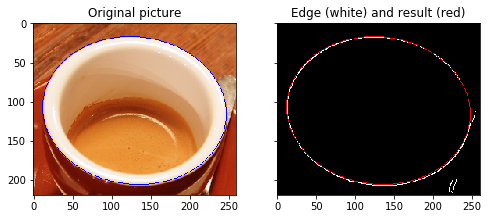

In [15]:
import matplotlib.pyplot as plt

from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

# Load picture, convert to grayscale and detect edges
image_rgb = data.coffee()[0:220, 160:420]
image_gray = color.rgb2gray(image_rgb)
edges = canny(image_gray, sigma=2.0,
              low_threshold=0.55, high_threshold=0.8)

# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
result = hough_ellipse(edges, accuracy=20, threshold=250,
                       min_size=100, max_size=120)
result.sort(order='accumulator')

# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
image_rgb[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = color.gray2rgb(img_as_ubyte(edges))
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),
                                sharex=True, sharey=True)

ax1.set_title('Original picture')
ax1.imshow(image_rgb)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

plt.show()

# Generalized Hough Transform

GHT was developed to detect analytically defined shapes (e.g., line, circle, ellipse etc.). In these cases, we have knowledge of the shape and aim to find out its location and orientation in the image. The Generalized Hough Transform or GHT, introduced by **Dana H. Ballard** in 1981, is the modification of the Hough Transform using the principle of template matching. This modification enables the Hough Transform to be used for not only the detection of an object described with an analytic function. Instead, it can also be used to detect an arbitrary object described with its model.

The GHT employs any template and the following algorithm:

- build reference table using the given reference image
- match table with original image
- find maximum points in the returned accumulator array

Reference: 
* Dana H. Ballard's paper on [Generalizing the Hough Transform to Detect Arbitrary Shapes](https://www.cs.bgu.ac.il/~icbv161/wiki.files/Readings/1981-Ballard-Generalizing_the_Hough_Transform_to_Detect_Arbitrary_Shapes.pdf) describes how to change to the Hough Transform in a simple way inorder to allow to detect irregular shapes. [This is an alternative link to the paper](http://www.cs.utexas.edu/~dana/HoughT.pdf).


### OpenCV Generalized Hough



In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import data
from matplotlib import cm
from skimage.feature import canny

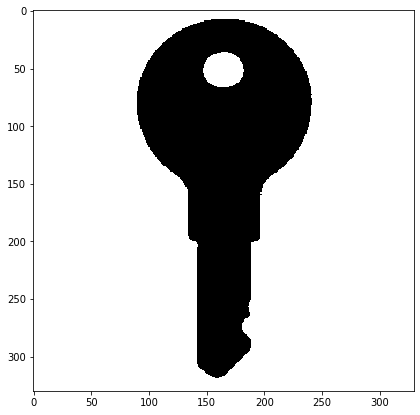

In [17]:
image = cv2.imread('../data/key1-template.png') # read as it is
plt.imshow(image)

In [ ]:
# All three find an arbitrary template in the grayscale image using the Generalized Hough Transform
alg1 = cv2.GeneralizedHoughGuil()
alg2 = cv2.GeneralizedHoughBallard()
alg2.setTemplate(image)
alg2

### Third-Party implementations:

In [ ]:
!git clone https://github.com/adl1995/generalised-hough-transform
!git clone https://github.com/vmonaco/general-hough
!git clone https://github.com/iakash2604/gen-hough-transform

# Credits

* The third-party Gits I've cited above
* [LearnOpenCV::Hough Transform with OpenCV (C++/Python) by Krutika Bapat](https://www.learnopencv.com/hough-transform-with-opencv-c-python/) (Hough lines & circles)

![rodape lapix ufsc](../rodape-CC.png)